# Variability due to dynamical or property change?

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

1. [Functions](##-Functions)
2. [Upwelling](##-Upwelling)
3. [Downwelling](##-Downwelling)
4. [Test with observations](##-Test-with-Observations)

## Functions

In [2]:
def means(s_t, do_no3, ta_dic):
    # make dictionary of mean transport and tracer concentrations of each WM and of JdF inflow

    # set up dictionary
    # for each variable, saved in the order total -> loop -> fresh -> south -> cuc -> off_d -> off_s -> north
    d = {'section':['total', 'loop', 'fresh', 'south', 'cuc', 'off_d', 'off_s', 'north'],
        'transport':np.zeros(8),'salt':np.zeros(8),'temp':np.zeros(8),
         'DO':np.zeros(8),'NO3':np.zeros(8),'TA':np.zeros(8),'DIC':np.zeros(8)}
    df = pd.DataFrame(d)

    # hours over which data was integrated
    start = 2401
    length =(np.max(s_t.init_t)-start+1) 

    # boundary definitions
    bdy_loo = 0
    bdy_sou = 2
    bdy_off = 3
    bdy_nor = 4

    saltdiv = 32
    sdiv = 33.5

    
    # total
    mydata= s_t
    boolean = ((abs(mydata.init_t-mydata.final_t) > 24) & ~np.isnan(mydata.final_section)) # total.. but not including tidal pumping or lost particles
    transport = mydata.init_transp[boolean].values
    df.loc[0,'transport'] = np.sum(transport)/length
    df.loc[0,'salt'] = np.average(mydata.init_salt[boolean], weights = transport)
    df.loc[0,'temp'] = np.average(mydata.init_temp[boolean], weights = transport)
    mydata = do_no3
    df.loc[0,'NO3'] = np.average(mydata.init_salt[boolean], weights = transport)
    df.loc[0,'DO'] = np.average(mydata.init_temp[boolean], weights = transport)
    mydata = ta_dic
    df.loc[0,'DIC'] = np.average(mydata.init_salt[boolean], weights = transport)
    df.loc[0,'TA'] = np.average(mydata.init_temp[boolean], weights = transport)

    # loop
    mydata= s_t
    boolean = (mydata.final_section==bdy_loo) & (abs(mydata.init_t-mydata.final_t) > 24)
    transport = mydata.init_transp[boolean].values
    df.loc[1,'transport'] = np.sum(transport)/length
    df.loc[1,'salt'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[1,'temp'] = np.average(mydata.final_temp[boolean], weights = transport)
    mydata = do_no3
    df.loc[1,'NO3'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[1,'DO'] = np.average(mydata.final_temp[boolean], weights = transport)
    mydata = ta_dic
    df.loc[1,'DIC'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[1,'TA'] = np.average(mydata.final_temp[boolean], weights = transport) 

    # fresh
    mydata= s_t
    boolean = ((mydata.final_section==bdy_sou) & (mydata.final_salt < saltdiv))
    transport = mydata.init_transp[boolean].values
    df.loc[2,'transport'] = np.sum(transport)/length
    df.loc[2,'salt'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[2,'temp'] = np.average(mydata.final_temp[boolean], weights = transport)
    mydata = do_no3
    df.loc[2,'NO3'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[2,'DO'] = np.average(mydata.final_temp[boolean], weights = transport)
    mydata = ta_dic
    df.loc[2,'DIC'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[2,'TA'] = np.average(mydata.final_temp[boolean], weights = transport)

    # south
    mydata= s_t
    boolean = (mydata.final_section==bdy_sou) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)
    transport = mydata.init_transp[boolean].values
    df.loc[3,'transport'] = np.sum(transport)/length
    df.loc[3,'salt'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[3,'temp'] = np.average(mydata.final_temp[boolean], weights = transport)
    mydata = do_no3
    df.loc[3,'NO3'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[3,'DO'] = np.average(mydata.final_temp[boolean], weights = transport)
    mydata = ta_dic
    df.loc[3,'DIC'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[3,'TA'] = np.average(mydata.final_temp[boolean], weights = transport)

    # cuc
    mydata= s_t
    boolean = (mydata.final_section==bdy_sou) & (mydata.final_salt >= sdiv)
    transport = mydata.init_transp[boolean].values
    df.loc[4,'transport'] = np.sum(transport)/length
    df.loc[4,'salt'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[4,'temp'] = np.average(mydata.final_temp[boolean], weights = transport)
    mydata = do_no3
    df.loc[4,'NO3'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[4,'DO'] = np.average(mydata.final_temp[boolean], weights = transport)
    mydata = ta_dic
    df.loc[4,'DIC'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[4,'TA'] = np.average(mydata.final_temp[boolean], weights = transport)

    # off_d
    mydata= s_t
    boolean = (mydata.final_section==bdy_off) & (mydata.final_depth > 120)
    transport = mydata.init_transp[boolean].values
    df.loc[5, 'transport'] = np.sum(transport)/length
    df.loc[5, 'salt'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[5, 'temp'] = np.average(mydata.final_temp[boolean], weights = transport)
    mydata = do_no3
    df.loc[5, 'NO3'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[5, 'DO'] = np.average(mydata.final_temp[boolean], weights = transport)
    mydata = ta_dic
    df.loc[5, 'DIC'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[5, 'TA'] = np.average(mydata.final_temp[boolean], weights = transport)

    # off_s
    mydata= s_t
    boolean = (mydata.final_section==bdy_off) & (mydata.final_depth <=120)
    transport = mydata.init_transp[boolean].values
    df.loc[6,'transport'] = np.sum(transport)/length
    df.loc[6,'salt'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[6,'temp'] = np.average(mydata.final_temp[boolean], weights = transport)
    mydata = do_no3
    df.loc[6,'NO3'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[6,'DO'] = np.average(mydata.final_temp[boolean], weights = transport)
    mydata = ta_dic
    df.loc[6,'DIC'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[6,'TA'] = np.average(mydata.final_temp[boolean], weights = transport)

    # north
    mydata= s_t
    boolean = (mydata.final_section==bdy_nor)
    transport = mydata.init_transp[boolean].values
    df.loc[7,'transport'] = np.sum(transport)/length
    df.loc[7,'salt'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[7,'temp'] = np.average(mydata.final_temp[boolean], weights = transport)
    mydata = do_no3
    df.loc[7,'NO3'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[7,'DO'] = np.average(mydata.final_temp[boolean], weights = transport)
    mydata = ta_dic
    df.loc[7,'DIC'] = np.average(mydata.final_salt[boolean], weights = transport)
    df.loc[7,'TA'] = np.average(mydata.final_temp[boolean], weights = transport)

    return df

def decomp(data,base):
    d = {'section':['total','loop', 'fresh', 'south', 'cuc', 'off_d', 'off_s', 'north'],
        'saltP':np.zeros(8),'saltQ':np.zeros(8),'saltSUM':np.zeros(8),
        'tempP':np.zeros(8),'tempQ':np.zeros(8),'tempSUM':np.zeros(8),
        'DOP':np.zeros(8),'DOQ':np.zeros(8),'DOSUM':np.zeros(8),
        'TAP':np.zeros(8),'TAQ':np.zeros(8),'TASUM':np.zeros(8),
        'NO3P':np.zeros(8),'NO3Q':np.zeros(8),'NO3SUM':np.zeros(8),
        'DICP':np.zeros(8),'DICQ':np.zeros(8),'DICSUM':np.zeros(8)}
    df = pd.DataFrame(d)

    # salt
    df['saltP'] = (data.salt[1:] - base.salt[1:])*(data.transport[1:]/data.transport[0])
    # (up22.salt[1:] - up_b.salt[1:])*(up22.transport[1:]/up22.transport[0])
    df['saltQ'] = ((data.transport[1:]/data.transport[0]) - (base.transport[1:]/base.transport[0]))*data.salt[1:]
    # ((up22.transport[1:]/up22.transport[0]) - (up_b.transport[1:]/up_b.transport[0]))*up22.salt[1:]
    df['saltSUM'] = df.saltP + df.saltQ

    # temp
    df['tempP'] = (data.temp[1:] - base.temp[1:])*(data.transport[1:]/data.transport[0])
    df['tempQ'] = ((data.transport[1:]/data.transport[0]) - (base.transport[1:]/base.transport[0]))*data.temp[1:]
    df['tempSUM'] = df.tempP + df.tempQ

    # do
    df['DOP'] = (data.DO[1:] - base.DO[1:])*(data.transport[1:]/data.transport[0])
    df['DOQ'] = ((data.transport[1:]/data.transport[0]) - (base.transport[1:]/base.transport[0]))*data.DO[1:]
    df['DOSUM'] = df.DOP + df.DOQ

    # ta
    df['TAP'] = (data.TA[1:] - base.TA[1:])*(data.transport[1:]/data.transport[0])
    df['TAQ'] = ((data.transport[1:]/data.transport[0]) - (base.transport[1:]/base.transport[0]))*data.TA[1:]
    df['TASUM'] = df.TAP + df.TAQ

    # dic
    df['DICP'] = (data.DIC[1:] - base.DIC[1:])*(data.transport[1:]/data.transport[0])
    df['DICQ'] = ((data.transport[1:]/data.transport[0]) - (base.transport[1:]/base.transport[0]))*data.DIC[1:]
    df['DICSUM'] = df.DICP + df.DICQ

    # no3
    df['NO3P'] = (data.NO3[1:] - base.NO3[1:])*(data.transport[1:]/data.transport[0])
    df['NO3Q'] = ((data.transport[1:]/data.transport[0]) - (base.transport[1:]/base.transport[0]))*data.NO3[1:]
    df['NO3SUM'] = df.NO3P + df.NO3Q

    return df

def stacked_bar(df, property):
    # Calculate absolute values
    df['absP'] = df[df.columns[2]].abs()
    df['absQ'] = df[df.columns[3]].abs()

    # Normalize the data within each year
    df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
    df['normP'] = df['absP'] / df['total_abs']
    df['normQ'] = df['absQ'] / df['total_abs']

    # Aggregate normalized values by year and section
    agg_df = df.groupby(['year', 'section'])[['normP', 'normQ']].sum().reset_index()

    # Pivot the DataFrame for plotting
    pivotP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
    pivotQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)

    # Plotting
    fig = plt.figure(constrained_layout=True, figsize=[8,6])
    gs = GridSpec(1, 5, figure=fig)
    ax = fig.add_subplot(gs[0, :4])
    ax2 = fig.add_subplot(gs[0, 4])

    # Assign colors to each section
    colors = ['midnightblue','magenta','mediumspringgreen','darkviolet','deepskyblue','red']#plt.cm.tab20(np.linspace(0, 1, len(pivotP.columns)))

    # Plot normalized saltP values (left side)
    left_cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(pivotP.columns):
        bars = ax.barh(pivotP.index, -pivotP[section], left=-left_cum_values, color=colors[i % len(colors)], label=section)
        left_cum_values += pivotP[section]

    # Plot normalized saltQ values (right side)
    right_cum_values = np.zeros(len(pivotQ))
    for i, section in enumerate(pivotQ.columns):
        bars = ax.barh(pivotQ.index, pivotQ[section], left=right_cum_values, color=colors[i % len(colors)])
        right_cum_values += pivotQ[section]

    # Customize plot
    ax.axvline(0, color='grey', linewidth=2)
    ax.set_xlabel('Normalized Absolute Values')
    title = 'Contribution to change in ' + property
    ax.set_title(title)
    # ax.set_xlim(-0.1,1.1)
    ax.set_xticks([0,1])
    ax.invert_yaxis()
    ax.set_yticks(list(set(df.year)))

    ax2.sharey(ax)

    plt.tight_layout()

    return ax2

## Upwelling

In [3]:
up13 = means(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20131024/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20131024/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20131024/ariane_positions_quantitative.nc'))

up14 = means(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20140903/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20140903/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20140903/ariane_positions_quantitative.nc'))

up15 = means(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20150905/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20150905/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20150905/ariane_positions_quantitative.nc'))

up16 = means(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20160913/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20160913/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20160913/ariane_positions_quantitative.nc'))

In [4]:
up21 = means(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20210922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20210922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20210922/ariane_positions_quantitative.nc'))
up21

,section,transport,salt,temp,DO,NO3,TA,DIC
0,total,175100.761758,33.437343,6.878566,89.066218,32.566350,2296.140886,2292.133090
1,loop,47892.743807,32.147956,8.268352,162.824418,29.531483,2235.363649,2198.926194
2,fresh,914.591989,30.001792,9.055838,308.683101,7.427832,2159.874902,1990.992429
3,south,6746.388401,32.942214,8.475358,186.544382,20.645642,2272.794101,2189.361709
4,cuc,42358.474133,33.872269,6.262225,63.342383,37.089241,2322.278085,2324.193676
5,off_d,37948.053324,33.758364,6.382110,88.199850,33.918284,2314.229495,2298.032249
6,off_s,5594.891591,32.803437,7.970548,220.395141,15.808643,2263.994608,2151.010730
7,north,33645.618513,33.190089,7.281880,158.181221,23.791523,2282.609135,2219.732483


In [5]:
up22 = means(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20221015/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20221015/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20221015/ariane_positions_quantitative.nc'))
up22

,section,transport,salt,temp,DO,NO3,TA,DIC
0,total,183358.656226,33.418979,6.984773,84.578336,32.373358,2292.223650,2294.921888
1,loop,46232.389609,31.884409,8.864029,153.723608,28.829758,2220.301999,2190.337044
2,fresh,356.272486,29.036857,9.929378,317.042335,4.613243,2121.004952,1931.535035
3,south,11000.238644,33.246944,7.568788,132.822180,26.288885,2282.748814,2245.331530
4,cuc,64658.987936,33.829425,6.270541,69.999886,36.191345,2316.929993,2316.157508
5,off_d,21013.116560,33.627031,6.743327,104.803427,31.373453,2303.441332,2279.050300
6,off_s,14007.282971,32.829435,7.984797,210.462044,16.138737,2266.545205,2159.678746
7,north,26090.368020,32.955813,7.913972,178.795639,19.905506,2270.522609,2189.939819


In [6]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['total', 'loop', 'fresh', 'south', 'cuc', 'off_d', 'off_s', 'north'],
     'transport':np.mean([up13.transport,up14.transport,up15.transport,up16.transport,up21.transport,up22.transport],axis=0),
     'salt':np.mean([up13.salt,up14.salt,up15.salt,up16.salt,up21.salt,up22.salt],axis=0),
     'temp':np.mean([up13.temp,up14.temp,up15.temp,up16.temp,up21.temp,up22.temp],axis=0),
     'DO':np.mean([up13.DO,up14.DO,up15.DO,up16.DO,up21.DO,up22.DO],axis=0),
     'NO3':np.mean([up13.NO3,up14.NO3,up15.NO3,up16.NO3,up21.NO3,up22.NO3],axis=0),
     'TA':np.mean([up13.TA,up14.TA,up15.TA,up16.TA,up21.TA,up22.TA],axis=0),
     'DIC':np.mean([up13.DIC,up14.DIC,up15.DIC,up16.DIC,up21.DIC,up22.DIC],axis=0)}
up_b = pd.DataFrame(d)

up_b

,section,transport,salt,temp,DO,NO3,TA,DIC
0,total,179752.659385,33.420818,7.077270,92.599148,31.843368,2296.172138,2286.358414
1,loop,45212.058422,32.011473,8.774522,162.924126,27.688624,2230.587780,2187.151114
2,fresh,2148.454424,29.302354,10.966366,305.538044,4.786538,2131.473687,1940.624755
3,south,7476.247372,32.965816,8.833011,192.200751,19.622001,2274.100494,2182.859434
4,cuc,44095.778749,33.894581,6.210466,66.733372,36.755873,2324.469080,2321.429703
5,off_d,39093.605366,33.732883,6.606013,93.516062,33.148468,2312.358394,2292.278693
6,off_s,8429.850441,32.841961,8.480070,215.776777,16.059099,2267.160582,2154.769739
7,north,33296.664611,33.214928,7.558138,156.287164,23.739438,2284.439876,2219.005522


In [7]:
# math!
math_up13 = decomp(up13,up_b)[1:]
math_up14 = decomp(up14,up_b)[1:]
math_up15 = decomp(up15,up_b)[1:]
math_up16 = decomp(up16,up_b)[1:]
math_up21 = decomp(up21,up_b)[1:]
math_up22 = decomp(up22,up_b)[1:]

# add year 
math_up13['year'] = 2013
math_up14['year'] = 2014
math_up15['year'] = 2015
math_up16['year'] = 2016
math_up21['year'] = 2021
math_up22['year'] = 2022

/tmp/ipykernel_67676/594355245.py:233: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'Salinity (g/kg)')

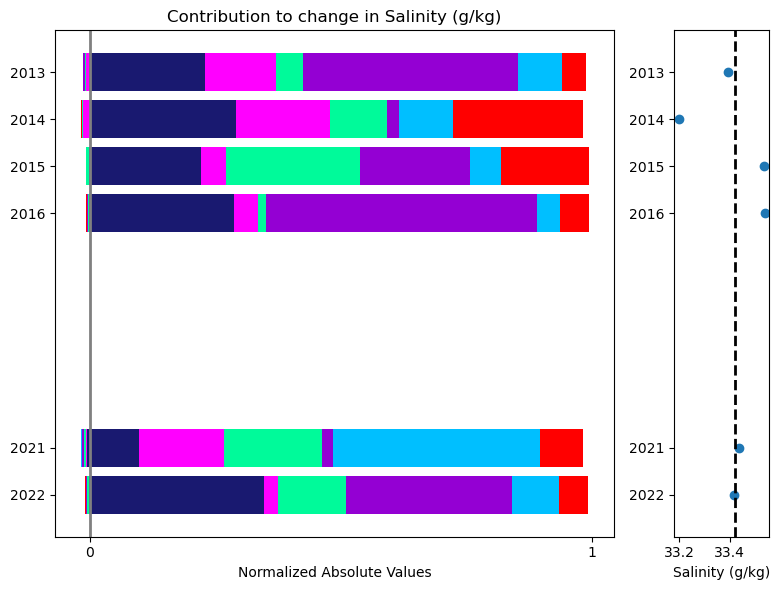

In [8]:
df = pd.concat([math_up13[['year','section','saltP','saltQ']][1:],math_up14[['year','section','saltP','saltQ']][1:],
    math_up15[['year','section','saltP','saltQ']][1:],math_up16[['year','section','saltP','saltQ']][1:],
    math_up21[['year','section','saltP','saltQ']][1:],math_up22[['year','section','saltP','saltQ']][1:]])
ax2 = stacked_bar(df,'Salinity (g/kg)')

# mean property inflow to JdF
ax2.scatter([up13.salt[0],up14.salt[0],up15.salt[0],up16.salt[0],up21.salt[0],up22.salt[0]], [2013,2014,2015,2016,2021,2022])
ax2.axvline(up_b.salt[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('Salinity (g/kg)')
# ax2.set_xlim([33.4,33.45])
# ax2.set_xticks([33.41,33.44])


/tmp/ipykernel_67676/594355245.py:233: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'Temperature ($^\\circ C$)')

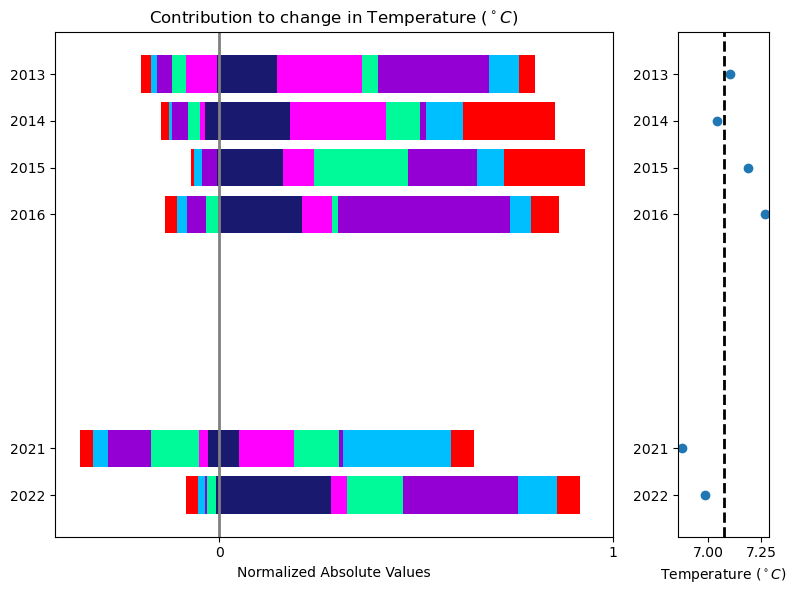

In [9]:
df = pd.concat([math_up13[['year','section','tempP','tempQ']][1:],math_up14[['year','section','tempP','tempQ']][1:],
    math_up15[['year','section','tempP','tempQ']][1:],math_up16[['year','section','tempP','tempQ']][1:],
    math_up21[['year','section','tempP','tempQ']][1:],math_up22[['year','section','tempP','tempQ']][1:]])
ax2 = stacked_bar(df,'Temperature ($^\circ C$)')

# mean property inflow to JdF
ax2.scatter([up13.temp[0],up14.temp[0],up15.temp[0],up16.temp[0],up21.temp[0],up22.temp[0]], [2013,2014,2015,2016,2021,2022])
ax2.axvline(up_b.temp[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('Temperature ($^\circ C$)')
# ax2.set_xlim([33.4,33.45])
# ax2.set_xticks([33.41,33.44])

/tmp/ipykernel_67676/594355245.py:233: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'DO ()')

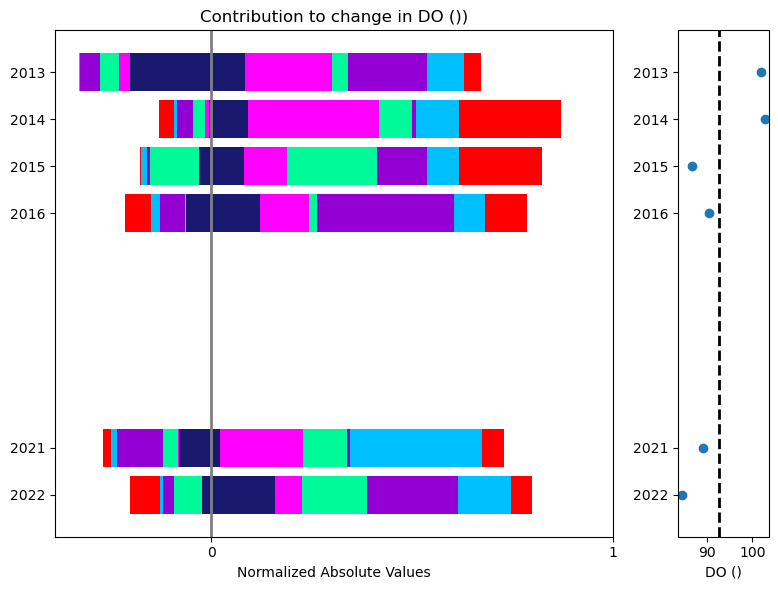

In [10]:
df = pd.concat([math_up13[['year','section','DOP','DOQ']][1:],math_up14[['year','section','DOP','DOQ']][1:],
    math_up15[['year','section','DOP','DOQ']][1:],math_up16[['year','section','DOP','DOQ']][1:],
    math_up21[['year','section','DOP','DOQ']][1:],math_up22[['year','section','DOP','DOQ']][1:]])
ax2 = stacked_bar(df,'DO ())')

# mean property inflow to JdF
ax2.scatter([up13.DO[0],up14.DO[0],up15.DO[0],up16.DO[0],up21.DO[0],up22.DO[0]], [2013,2014,2015,2016,2021,2022])
ax2.axvline(up_b.DO[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('DO ()')
# ax2.set_xlim([33.4,33.45])
# ax2.set_xticks([33.41,33.44])

/tmp/ipykernel_67676/594355245.py:233: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'NO3 ()')

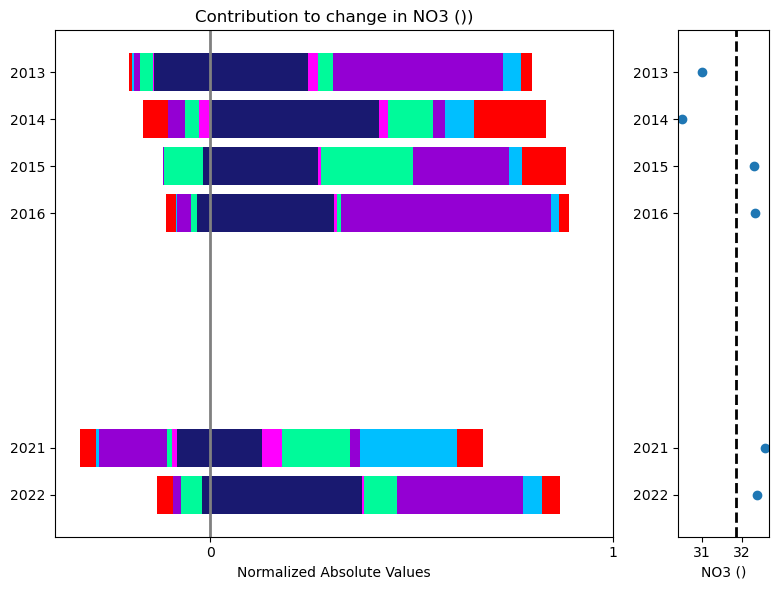

In [11]:
df = pd.concat([math_up13[['year','section','NO3P','NO3Q']][1:],math_up14[['year','section','NO3P','NO3Q']][1:],
    math_up15[['year','section','NO3P','NO3Q']][1:],math_up16[['year','section','NO3P','NO3Q']][1:],
    math_up21[['year','section','NO3P','NO3Q']][1:],math_up22[['year','section','NO3P','NO3Q']][1:]])
ax2 = stacked_bar(df,'NO3 ())')

# mean property inflow to JdF
ax2.scatter([up13.NO3[0],up14.NO3[0],up15.NO3[0],up16.NO3[0],up21.NO3[0],up22.NO3[0]], [2013,2014,2015,2016,2021,2022])
ax2.axvline(up_b.NO3[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('NO3 ()')
# ax2.set_xlim([33.4,33.45])
# ax2.set_xticks([33.41,33.44])

/tmp/ipykernel_67676/594355245.py:233: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'TA ()')

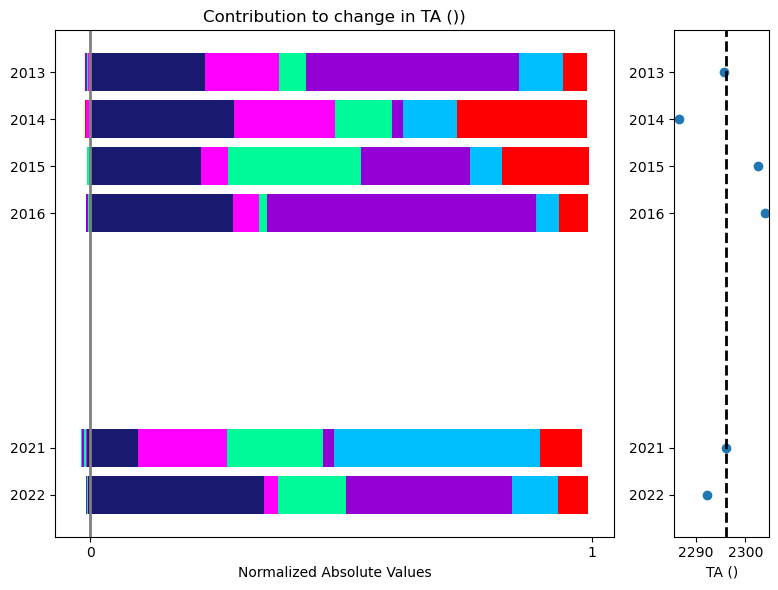

In [12]:
df = pd.concat([math_up13[['year','section','TAP','TAQ']][1:],math_up14[['year','section','TAP','TAQ']][1:],
    math_up15[['year','section','TAP','TAQ']][1:],math_up16[['year','section','TAP','TAQ']][1:],
    math_up21[['year','section','TAP','TAQ']][1:],math_up22[['year','section','TAP','TAQ']][1:]])
ax2 = stacked_bar(df,'TA ())')

# mean property inflow to JdF
ax2.scatter([up13.TA[0],up14.TA[0],up15.TA[0],up16.TA[0],up21.TA[0],up22.TA[0]], [2013,2014,2015,2016,2021,2022])
ax2.axvline(up_b.TA[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('TA ()')
# ax2.set_xlim([33.4,33.45])
# ax2.set_xticks([33.41,33.44])

/tmp/ipykernel_67676/594355245.py:233: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'DIC ()')

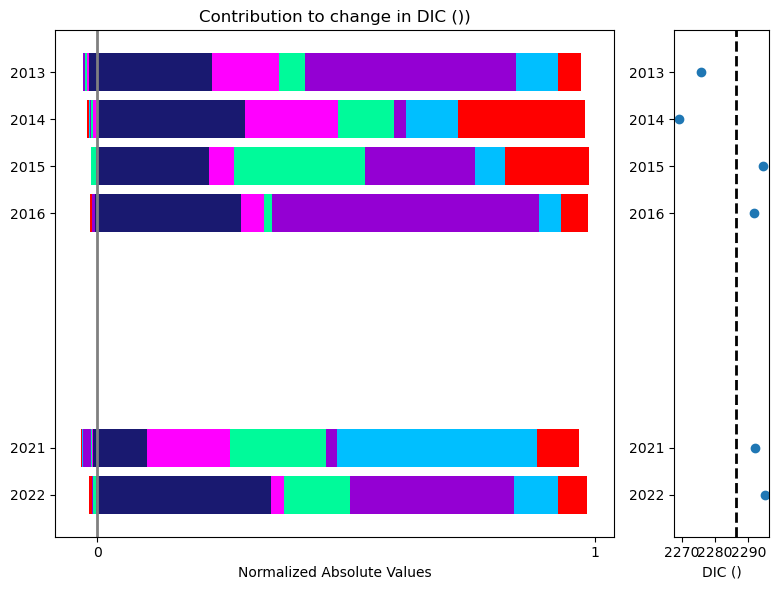

In [13]:
df = pd.concat([math_up13[['year','section','DICP','DICQ']][1:],math_up14[['year','section','DICP','DICQ']][1:],
    math_up15[['year','section','DICP','DICQ']][1:],math_up16[['year','section','DICP','DICQ']][1:],
    math_up21[['year','section','DICP','DICQ']][1:],math_up22[['year','section','DICP','DICQ']][1:]])
ax2 = stacked_bar(df,'DIC ())')

# mean property inflow to JdF
ax2.scatter([up13.DIC[0],up14.DIC[0],up15.DIC[0],up16.DIC[0],up21.DIC[0],up22.DIC[0]], [2013,2014,2015,2016,2021,2022])
ax2.axvline(up_b.DIC[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('DIC ()')
# ax2.set_xlim([33.4,33.45])
# ax2.set_xticks([33.41,33.44])

## Downwelling

In [14]:
dw13 = means(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20140306/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20140306/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20140306/ariane_positions_quantitative.nc'))

dw15 = means(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20160319/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20160319/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20160319/ariane_positions_quantitative.nc'))

dw20 = means(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20210202/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20210202/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20210202/ariane_positions_quantitative.nc'))

dw21 = means(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20220125/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20220125/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20220125/ariane_positions_quantitative.nc'))


In [15]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['total', 'loop', 'fresh', 'south', 'cuc', 'off_d', 'off_s', 'north'],
     'transport':np.mean([dw13.transport,dw15.transport,dw20.transport,dw21.transport],axis=0),
     'salt':np.mean([dw13.salt,dw15.salt,dw20.salt,dw21.salt],axis=0),
     'temp':np.mean([dw13.temp,dw15.temp,dw20.temp,dw21.temp],axis=0),
     'DO':np.mean([dw13.DO,dw15.DO,dw20.DO,dw21.DO],axis=0),
     'NO3':np.mean([dw13.NO3,dw15.NO3,dw20.NO3,dw21.NO3],axis=0),
     'TA':np.mean([dw13.TA,dw15.TA,dw20.TA,dw21.TA],axis=0),
     'DIC':np.mean([dw13.DIC,dw15.DIC,dw20.DIC,dw21.DIC],axis=0)}
dw_b = pd.DataFrame(d)

dw_b

,section,transport,salt,temp,DO,NO3,TA,DIC
0,total,150178.360992,32.200130,8.208170,175.229957,24.009306,2238.486631,2177.914402
1,loop,59944.955159,31.796951,8.135603,186.484206,26.993183,2216.201053,2170.039249
2,fresh,23815.827964,30.099071,9.697718,290.655874,8.252876,2161.287090,1997.320253
3,south,32306.404701,32.824618,9.150925,187.928469,18.443966,2267.133037,2177.033951
4,cuc,21801.487214,33.746755,6.749115,76.259185,34.982837,2310.681314,2309.075950
5,off_d,4574.751447,33.537966,7.026547,109.124258,30.467766,2298.443838,2272.475643
6,off_s,5086.941341,32.728199,9.553471,212.749391,13.707705,2261.174226,2139.056692
7,north,2647.993166,32.714026,9.393768,195.967365,16.368736,2260.237732,2158.730518


In [16]:
# math! 
math_dw13 = decomp(dw13,dw_b)[1:]
math_dw15 = decomp(dw15,dw_b)[1:]
math_dw20 = decomp(dw20,dw_b)[1:]
math_dw21 = decomp(dw21,dw_b)[1:]

# add year 
math_dw13['year'] = 2013
math_dw15['year'] = 2015
math_dw20['year'] = 2020
math_dw21['year'] = 2021

/tmp/ipykernel_67676/594355245.py:233: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'Salinity (g/kg)')

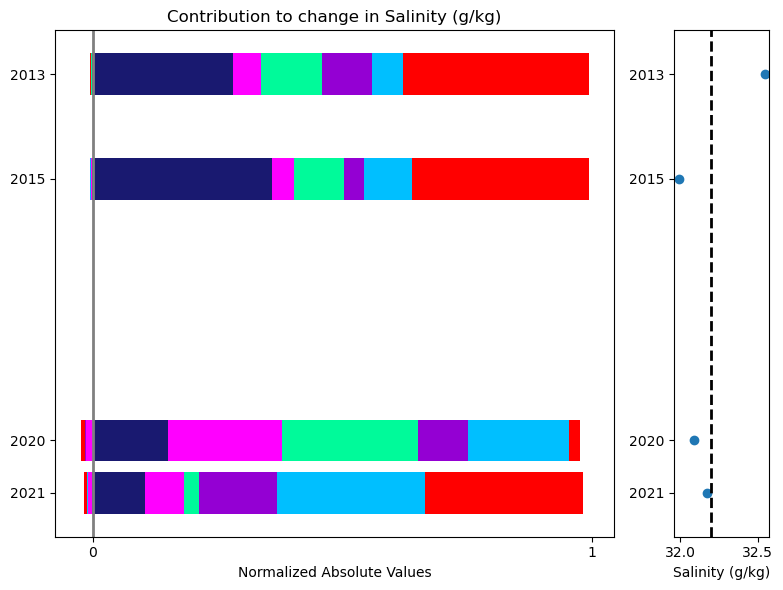

In [17]:
df = pd.concat([math_dw13[['year','section','saltP','saltQ']][1:],
    math_dw15[['year','section','saltP','saltQ']][1:],
    math_dw20[['year','section','saltP','saltQ']][1:],math_dw21[['year','section','saltP','saltQ']][1:]])
ax2 = stacked_bar(df,'Salinity (g/kg)')

# mean property inflow to JdF
ax2.scatter([dw13.salt[0],dw15.salt[0],dw20.salt[0],dw21.salt[0]], [2013,2015,2020,2021])
ax2.axvline(dw_b.salt[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('Salinity (g/kg)')
# ax2.set_xlim([33.4,33.45])
# ax2.set_xticks([33.41,33.44])

/tmp/ipykernel_67676/594355245.py:233: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'Temperature ($^\\circ C$)')

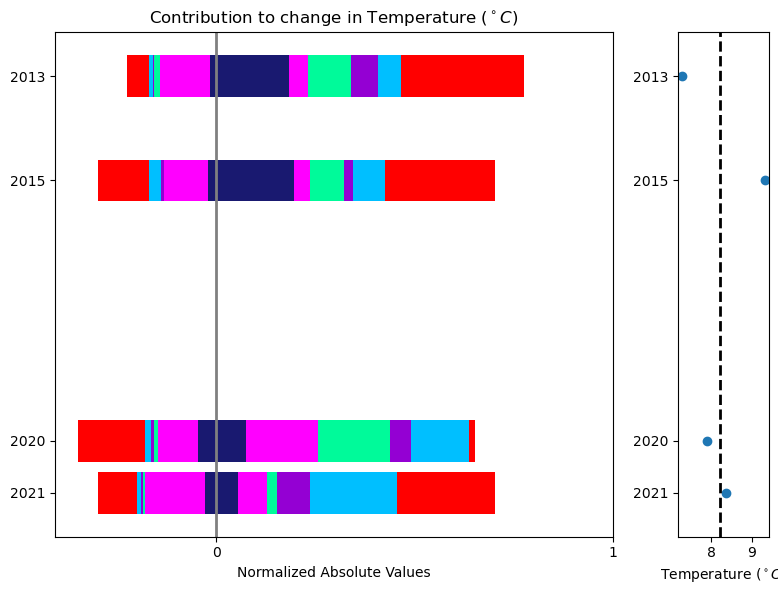

In [18]:
df = pd.concat([math_dw13[['year','section','tempP','tempQ']][1:],
    math_dw15[['year','section','tempP','tempQ']][1:],
    math_dw20[['year','section','tempP','tempQ']][1:],math_dw21[['year','section','tempP','tempQ']][1:]])
ax2 = stacked_bar(df,'Temperature ($^\circ C$)')

# mean property inflow to JdF
ax2.scatter([dw13.temp[0],dw15.temp[0],dw20.temp[0],dw21.temp[0]], [2013,2015,2020,2021])
ax2.axvline(dw_b.temp[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('Temperature ($^\circ C$)')

/tmp/ipykernel_67676/594355245.py:233: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'DO ()')

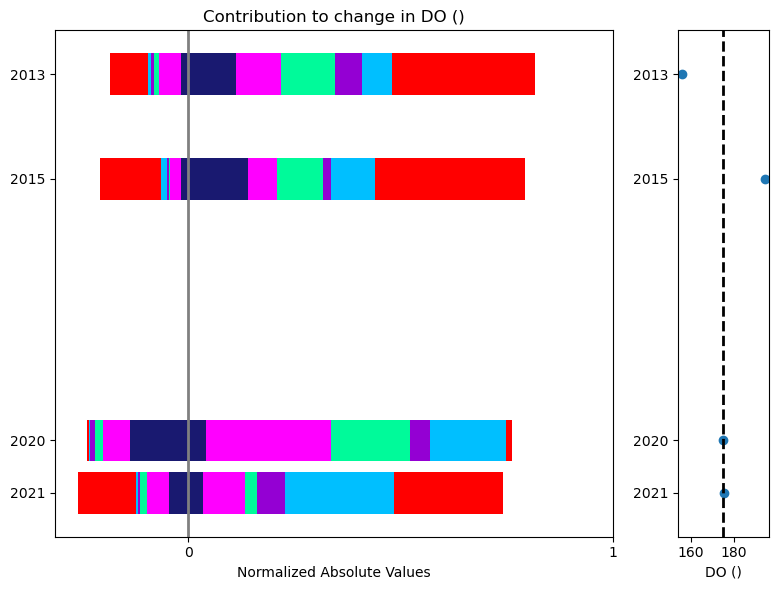

In [19]:
df = pd.concat([math_dw13[['year','section','DOP','DOQ']][1:],
    math_dw15[['year','section','DOP','DOQ']][1:],
    math_dw20[['year','section','DOP','DOQ']][1:],math_dw21[['year','section','DOP','DOQ']][1:]])
ax2 = stacked_bar(df,'DO ()')

# mean property inflow to JdF
ax2.scatter([dw13.DO[0],dw15.DO[0],dw20.DO[0],dw21.DO[0]], [2013,2015,2020,2021])
ax2.axvline(dw_b.DO[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('DO ()')

/tmp/ipykernel_67676/594355245.py:233: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'Nitrate ()')

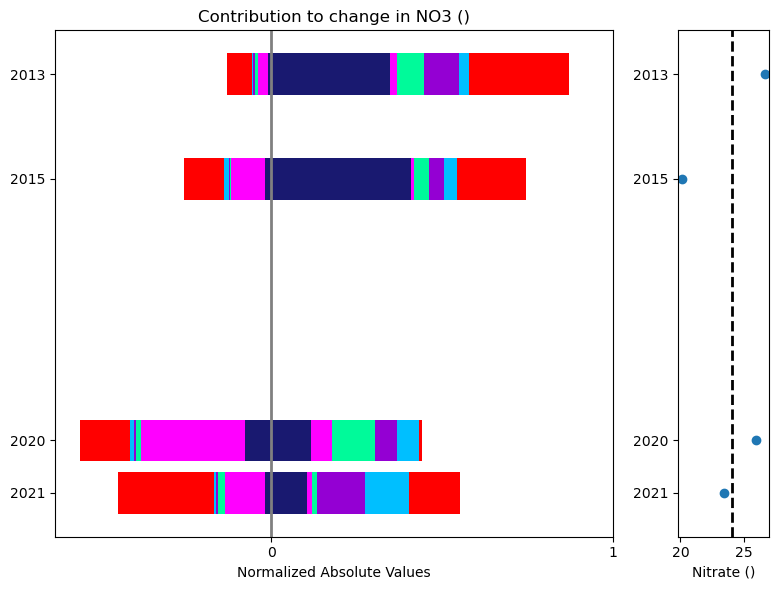

In [20]:
df = pd.concat([math_dw13[['year','section','NO3P','NO3Q']][1:],
    math_dw15[['year','section','NO3P','NO3Q']][1:],
    math_dw20[['year','section','NO3P','NO3Q']][1:],math_dw21[['year','section','NO3P','NO3Q']][1:]])
ax2 = stacked_bar(df,'NO3 ()')

# mean property inflow to JdF
ax2.scatter([dw13.NO3[0],dw15.NO3[0],dw20.NO3[0],dw21.NO3[0]], [2013,2015,2020,2021])
ax2.axvline(dw_b.NO3[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('Nitrate ()')

/tmp/ipykernel_67676/594355245.py:233: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'TA ()')

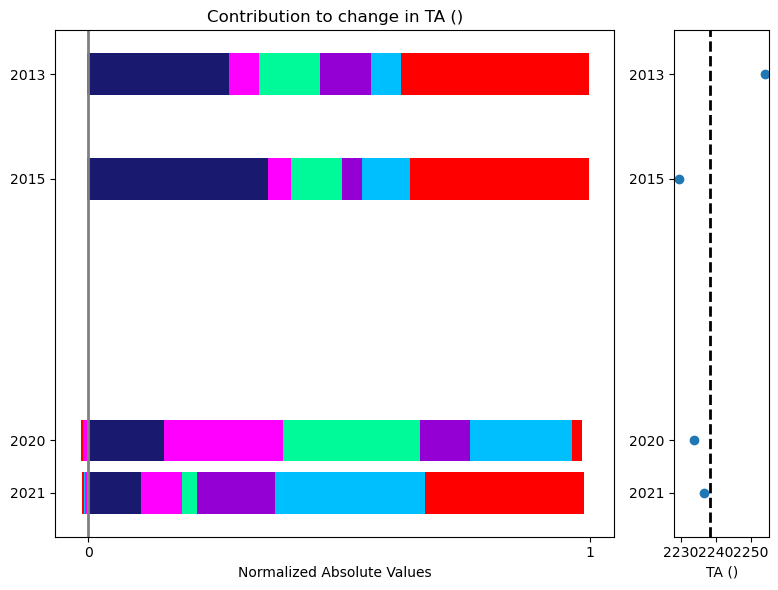

In [21]:
df = pd.concat([math_dw13[['year','section','TAP','TAQ']][1:],
    math_dw15[['year','section','TAP','TAQ']][1:],
    math_dw20[['year','section','TAP','TAQ']][1:],math_dw21[['year','section','TAP','TAQ']][1:]])
ax2 = stacked_bar(df,'TA ()')

# mean property inflow to JdF
ax2.scatter([dw13.TA[0],dw15.TA[0],dw20.TA[0],dw21.TA[0]], [2013,2015,2020,2021])
ax2.axvline(dw_b.TA[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('TA ()')

/tmp/ipykernel_67676/594355245.py:233: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'DIC ()')

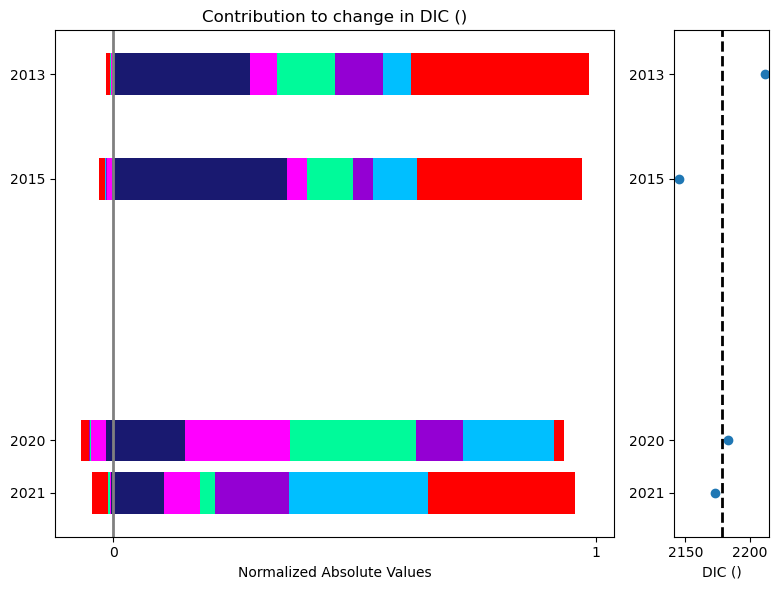

In [22]:
df = pd.concat([math_dw13[['year','section','DICP','DICQ']][1:],
    math_dw15[['year','section','DICP','DICQ']][1:],
    math_dw20[['year','section','DICP','DICQ']][1:],math_dw21[['year','section','DICP','DICQ']][1:]])
ax2 = stacked_bar(df,'DIC ()')

# mean property inflow to JdF
ax2.scatter([dw13.DIC[0],dw15.DIC[0],dw20.DIC[0],dw21.DIC[0]], [2013,2015,2020,2021])
ax2.axvline(dw_b.DIC[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('DIC ()')

## All together now